# Fixed Income Securities - Group Project
### Autores:
- Luís Ribeiro (nº20231536)
- Tiago Bellas (nº20231131)
- Fernando Tiago Reis (nº20231535)
- Renato Morais (nº20231135)

## Exercício 1

In [18]:
!pip install nelson-siegel-svensson
!pip install quantlib
!pip install seaborn

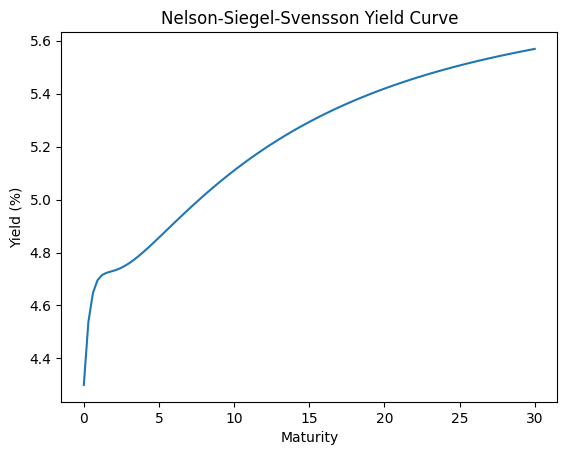

In [19]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

yield_curve = NelsonSiegelSvenssonCurve(
    beta0=5.9/100, 
    beta1=-1.6/100,
    beta2=-0.5/100,
    beta3=1/100,
    tau1=5,
    tau2=0.5
)
t = np.linspace(0, 30, 100)

plt.figure();
plt.plot(t, yield_curve(t)*100);
plt.title('Nelson-Siegel-Svensson Yield Curve');
plt.xlabel('Maturity');
plt.ylabel('Yield (%)');

### a) Compute the accrued interest

In [20]:
settlement_cpi = 251.14721
issue_cpi = 237.14365
index_ratio = settlement_cpi/issue_cpi
print("Index ratio: ", index_ratio)

Index ratio:  1.0590509591970942


In [21]:
import QuantLib as ql

def count_days(d1: ql.Date, d2: ql.Date):
    return ql.ActualActual(ql.ActualActual.ISDA).dayCount(d1, d2)

def count_years(d1: ql.Date, d2: ql.Date):
    return ql.ActualActual(ql.ActualActual.ISDA).yearFraction(d1, d2)

def settlement_lag_date(date: ql.Date, lag: int):
    return ql.TARGET().advance(date, lag, ql.Days)

def get_coupon_dates(issue_date:ql.Date, maturity_date: ql.Date, frequency: int):
    schedule = ql.Schedule(
        issue_date, 
        maturity_date, 
        ql.Period(frequency),
        ql.TARGET(),
        ql.Following,
        ql.Following,
        ql.DateGeneration.Backward, 
        False
    )
    return [dt for dt in schedule]

def ql_date_to_pandas_timestamp(date: ql.Date):
    return pd.Timestamp(date.year(), date.month(), date.dayOfMonth())

def get_monthly_dates(d1:ql.Date, d2:ql.Date):
    return [
        d1 + ql.Period(i, ql.Months) 
        for i in range((d2.year() - d1.year()) * 12 + d2.month() - d1.month() + 1 + 1)
    ]

Como cupões são pagos a 21/1 e 21/7, bond tem short first cupon. Logo juros corridos partem da data de issue...

In [22]:
maturity_date = ql.Date(21, 7, 2025)
trade_date = ql.Date(18, 9, 2020)
settlement_date = settlement_lag_date(trade_date, 1)
issue_date = ql.Date(31, 7, 2020)

coupon_frequency = ql.Semiannual
coupon_dates = get_coupon_dates(issue_date, maturity_date, coupon_frequency)[1:]
print("Coupon dates:", coupon_dates)

face_value = 25000
coupon_rate = 6.75/100

Coupon dates: [Date(21,1,2021), Date(21,7,2021), Date(21,1,2022), Date(21,7,2022), Date(23,1,2023), Date(21,7,2023), Date(22,1,2024), Date(22,7,2024), Date(21,1,2025), Date(21,7,2025)]


In [23]:
u = count_days(issue_date, settlement_date)
w = count_days(coupon_dates[-2], coupon_dates[-1])

print("Days between first coupon/issue date and settlement:", u)
print("Days between regular coupon payments:", w)

accrued_interest = face_value * coupon_rate/coupon_frequency * u/w
real_accrued_interest = index_ratio * accrued_interest

print("Accrued Interest ($): ", accrued_interest)
print("Real Accrued Interest ($): ", real_accrued_interest)

Days between first coupon/issue date and settlement: 52
Days between regular coupon payments: 181
Accrued Interest ($):  242.40331491712706
Real Accrued Interest ($):  256.71746317553874


### b) Simulate 10000 sceneratios for the inflation rate curve and CPI index

In [24]:
import numpy as np

years = round(count_years(settlement_date, maturity_date))
steps = 12 * years
dt = years / steps

constant_drift = 0.05321
diffusion_coefficient = 0.06358
n_scenarios = 10000

z = np.random.normal(0, np.sqrt(dt), size=(n_scenarios, steps))
cpi_scenarios = np.exp(
    (constant_drift*dt - 0.5 * diffusion_coefficient* dt **2) * dt
    + diffusion_coefficient * dt * z
)
cpi_scenarios = np.vstack([np.ones(n_scenarios), cpi_scenarios.T])
cpi_scenarios = settlement_cpi * cpi_scenarios.cumprod(axis=0)

t = np.linspace(0, years, steps + 1)
tt = np.full(shape=(n_scenarios, steps + 1), fill_value=t).T


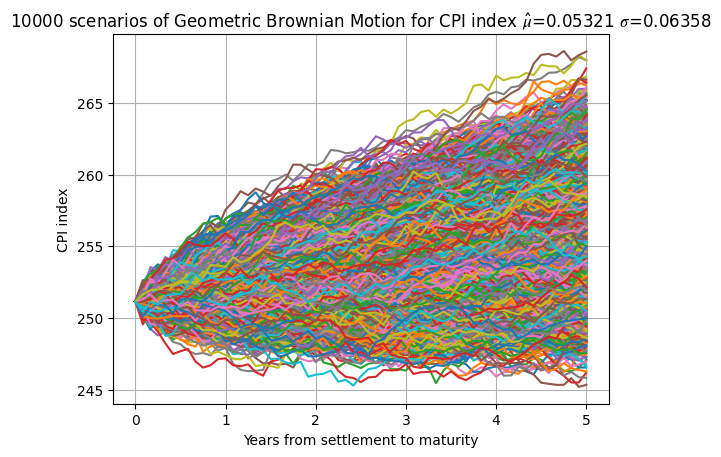

In [25]:
plt.plot(tt, cpi_scenarios)
plt.xlabel("Years from settlement to maturity");
plt.ylabel("CPI index");
plt.grid(True);
plt.title(f"{n_scenarios} scenarios of Geometric Brownian Motion for CPI index $𝜇̂$={constant_drift} $𝜎$={diffusion_coefficient}");
plt.show()

In [26]:
print("Average CPI Index (basis-points): ", cpi_scenarios.mean())
print("Standard Deviation (basis-points): ", cpi_scenarios.std())

Average CPI Index (basis-points):  253.8205321223788
Standard Deviation (basis-points):  2.636369423810437


Inflation rate is given by:
$ \pi_t = \frac{CPI^R_t}{CPI^R_0} - 1 $

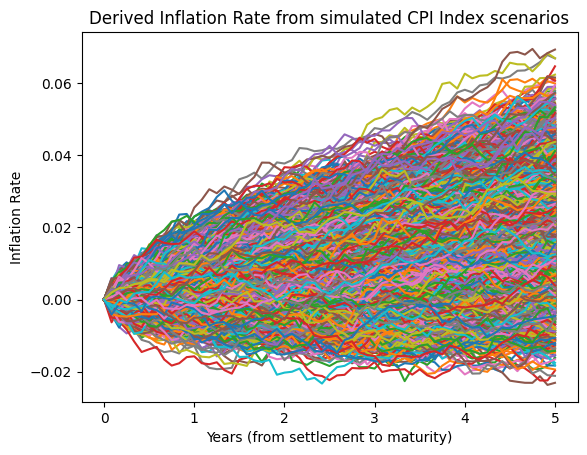

In [27]:
cpi_scenarios = cpi_scenarios.T #since each column is scenario

plt.figure();
plt.title("Derived Inflation Rate from simulated CPI Index scenarios");

inflation_scenarios = np.array([pd.Series(cpi_scenario)/cpi_scenario[0] - 1 for cpi_scenario in cpi_scenarios])

plt.plot(t, inflation_scenarios.T);
plt.xlabel("Years (from settlement to maturity)");
plt.ylabel("Inflation Rate");

In [28]:
print("Average inflation rate (%): ", inflation_scenarios.mean()*100)
print("Inflation Rate Standard Deviation (%): ", inflation_scenarios.std()*100)

Average inflation rate (%):  1.0644442844412811
Inflation Rate Standard Deviation (%):  1.049730723192361


### c) For each sceneraio, calculate the ILB cash flows and estimate their fair value

In [29]:
short_discount = count_days(issue_date, coupon_dates[0])/w
print(f"First coupon is short, so we'll only receive {round(short_discount*100, 2)}% of it.")

First coupon is short, so we'll only receive 96.13% of it.


In [39]:
cpi_dates = get_monthly_dates(settlement_date, maturity_date)
cpi_dates_pandas_timestamps = [ql_date_to_pandas_timestamp(date) for date in cpi_dates]
coupon_dates_pandas_timestamps = list(map(ql_date_to_pandas_timestamp, coupon_dates))
number_of_ilb_cashflows = len(coupon_dates)

scenarios_cashflows = []
scenarios_spot_rates = []
scenarios_inflation_rates = []

for cpi_scenario in cpi_scenarios:

    #US CPI Index starting at settlement in DataFrame (monthly)
    cpi_df = pd.DataFrame({'cpi': cpi_scenario[:-1]}, index=cpi_dates_pandas_timestamps)

    inflation_scenario_rates = []
    cpi_scenario_spot_rates = []

    cashflows = np.zeros(number_of_ilb_cashflows)
    
    for i in range(0, number_of_ilb_cashflows):

        #start with cashflow 0
        coupon_date = coupon_dates[i]
        cpi = np.float64(cpi_df[  (cpi_df.index.month == coupon_date.month()) & (cpi_df.index.year == coupon_date.year()) ].cpi)

        #Calculate inflatio growth (index ratio) & current spot rate (via Fisher)
        inflation_index = cpi/issue_cpi
        inflation_rate = inflation_index - 1
        inflation_scenario_rates.append(inflation_rate)
        inflation_adjusted_coupon = coupon_rate * inflation_index

        #calculate nominal yield rate before inflation
        tenor = (i+1)/coupon_frequency
        market_yield = yield_curve(tenor)

        #Fisher affected spot rate (inflation)
        #spot_rate = (1+market_yield)/(1+inflation_rate) - 1
        spot_rate = market_yield #assume spot rate is nominal, not real spot rate
        cpi_scenario_spot_rates.append(spot_rate)

        #Cash flows computations
        discount_factor = 1 / ( (1+spot_rate/coupon_frequency)**(i+1) ) #fix discount factor
        pv_cashflow = face_value * inflation_adjusted_coupon/coupon_frequency * discount_factor

        if i == 0: # is short first coupon
            cashflows[i] = pv_cashflow * short_discount
        elif i == number_of_ilb_cashflows-1: # if last coupon
            redemption_amount = face_value * inflation_index
            cashflows[i] = pv_cashflow + (redemption_amount * discount_factor)
        else: # normal case
            cashflows[i] = pv_cashflow

    #add to all cases
    scenarios_cashflows.append(cashflows)
    scenarios_spot_rates.append(np.array(cpi_scenario_spot_rates))
    scenarios_inflation_rates.append(np.array(inflation_scenario_rates))

C:\Users\rluis\AppData\Local\Temp\ipykernel_26452\2154356962.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cpi = np.float64(cpi_df[  (cpi_df.index.month == coupon_date.month()) & (cpi_df.index.year == coupon_date.year()) ].cpi)


0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373294664
0.7866903373

In [40]:
cashflows_df = pd.DataFrame(data=scenarios_cashflows, columns=coupon_dates)
cashflows_df

,"January 21st, 2021","July 21st, 2021","January 21st, 2022","July 21st, 2022","January 23rd, 2023","July 21st, 2023","January 22nd, 2024","July 22nd, 2024","January 21st, 2025","July 21st, 2025"
0,844.181371,860.577967,840.977267,820.826525,798.951758,782.844010,766.973978,748.045840,727.041318,21767.445229
1,842.206064,856.821164,837.729730,823.093456,806.909023,788.301014,770.879055,748.768190,730.127353,21960.769507
2,839.970820,854.979292,835.407263,813.135431,795.108745,778.348329,759.599140,742.633594,728.215599,21821.906324
3,838.611355,852.153808,832.982650,808.200657,793.388901,779.434958,759.439744,741.602090,725.442028,21541.155362
4,841.254235,852.781761,834.410036,815.741694,804.479883,788.576819,774.701377,757.847660,738.963933,21917.747165
...,...,...,...,...,...,...,...,...,...,...
9995,842.214696,856.378989,842.933778,824.454423,805.502399,791.746245,776.696465,761.514682,747.227890,22333.057821
9996,839.925037,850.806025,830.645921,813.598635,798.121528,779.119530,764.911949,748.422366,736.303413,22182.773183
9997,843.294359,863.179378,840.030226,820.212070,798.927170,780.537143,767.410446,750.045970,733.203350,21985.183426
9998,843.199040,861.605957,844.310238,830.542673,809.423438,794.100966,778.760116,755.780939,742.969638,22177.670966


In [41]:
cashflows_df.describe()

,"January 21st, 2021","July 21st, 2021","January 21st, 2022","July 21st, 2022","January 23rd, 2023","July 21st, 2023","January 22nd, 2024","July 22nd, 2024","January 21st, 2025","July 21st, 2025"
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,840.780795,855.983104,837.843929,820.099048,802.652391,785.358070,768.184536,751.115913,734.217944,21976.202984
std,2.555531,4.122905,5.119361,5.836754,6.432947,6.910192,7.336888,7.690468,8.001761,254.224196
min,829.859034,837.900579,816.826159,800.159990,777.489472,761.142502,740.251190,724.474337,706.896134,21047.557023
25%,839.006695,853.163847,834.329260,816.126630,798.233911,780.771475,763.273269,745.917099,728.765067,21799.783733
50%,840.781461,855.951341,837.794366,820.033834,802.570251,785.281237,768.183097,751.153501,734.312055,21976.018857
75%,842.509318,858.744775,841.185102,823.999937,807.028316,789.976386,773.029961,756.258482,739.500447,22146.725331
max,849.988156,873.102545,859.283626,844.688317,827.482906,810.844914,796.286598,783.588418,766.617525,22973.440530


### d) Estimate and analyse the inflation linked bond price distribution, including interest rate and inflation risk measures

In [42]:
cashflows_df['B0'] = cashflows_df.values.sum(axis=1)
cashflows_df

,"January 21st, 2021","July 21st, 2021","January 21st, 2022","July 21st, 2022","January 23rd, 2023","July 21st, 2023","January 22nd, 2024","July 22nd, 2024","January 21st, 2025","July 21st, 2025",B0
0,844.181371,860.577967,840.977267,820.826525,798.951758,782.844010,766.973978,748.045840,727.041318,21767.445229,28957.865263
1,842.206064,856.821164,837.729730,823.093456,806.909023,788.301014,770.879055,748.768190,730.127353,21960.769507,29165.604557
2,839.970820,854.979292,835.407263,813.135431,795.108745,778.348329,759.599140,742.633594,728.215599,21821.906324,28969.304537
3,838.611355,852.153808,832.982650,808.200657,793.388901,779.434958,759.439744,741.602090,725.442028,21541.155362,28672.411553
4,841.254235,852.781761,834.410036,815.741694,804.479883,788.576819,774.701377,757.847660,738.963933,21917.747165,29126.504564
...,...,...,...,...,...,...,...,...,...,...,...
9995,842.214696,856.378989,842.933778,824.454423,805.502399,791.746245,776.696465,761.514682,747.227890,22333.057821,29581.727390
9996,839.925037,850.806025,830.645921,813.598635,798.121528,779.119530,764.911949,748.422366,736.303413,22182.773183,29344.627589
9997,843.294359,863.179378,840.030226,820.212070,798.927170,780.537143,767.410446,750.045970,733.203350,21985.183426,29182.023537
9998,843.199040,861.605957,844.310238,830.542673,809.423438,794.100966,778.760116,755.780939,742.969638,22177.670966,29438.363971


count    10000.000000
mean     29172.438715
std        294.009970
min      28083.756105
25%      28968.841545
50%      29171.163666
75%      29371.118953
max      30341.902339
Name: B0, dtype: float64

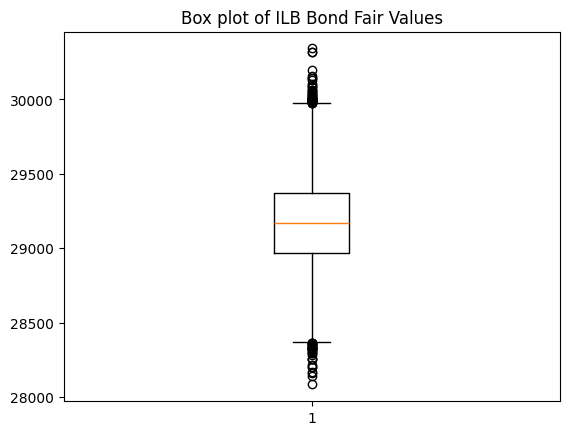

In [43]:
plt.figure()
plt.title("Box plot of ILB Bond Fair Values")
plt.boxplot(cashflows_df['B0']);

cashflows_df['B0'].describe()

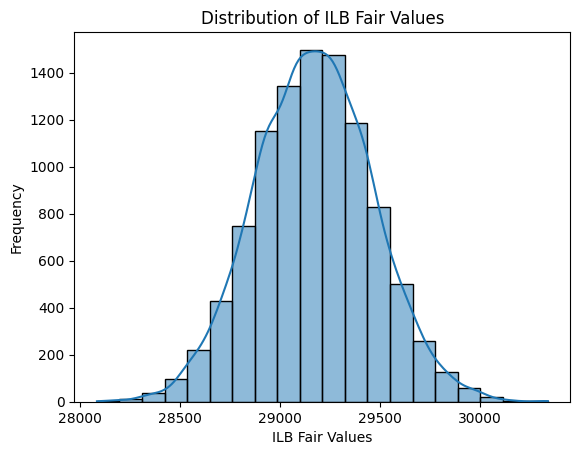

In [44]:
sns.histplot(cashflows_df['B0'], kde=True, bins=20)
plt.xlabel('ILB Fair Values')
plt.ylabel('Frequency')
plt.title('Distribution of ILB Fair Values');

count    10000.000000
mean       116.689755
std          1.176040
min        112.335024
25%        115.875366
50%        116.684655
75%        117.484476
max        121.367609
Name: B0, dtype: float64

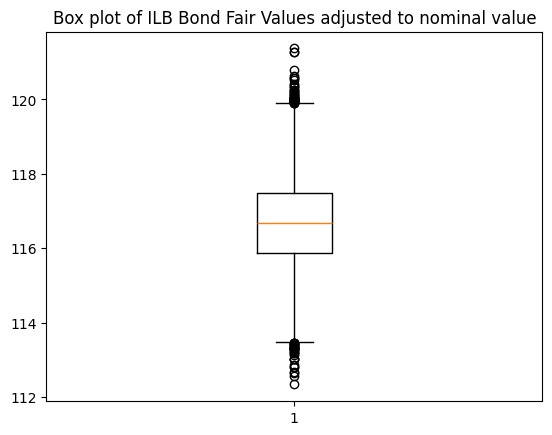

In [45]:
plt.figure()
plt.title("Box plot of ILB Bond Fair Values adjusted to nominal value")
plt.boxplot(cashflows_df['B0']/face_value * 100);

(cashflows_df['B0']/face_value * 100).describe()

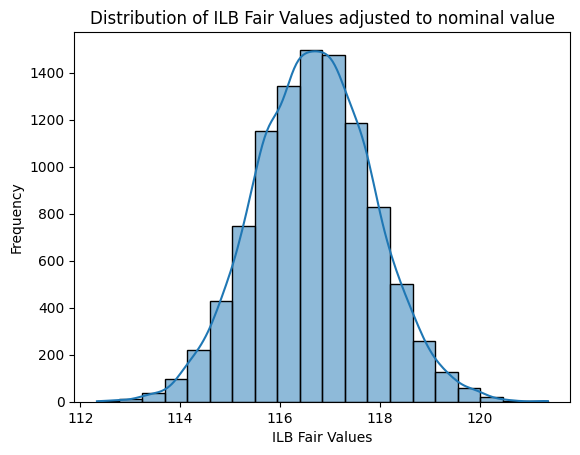

In [46]:
sns.histplot(cashflows_df['B0']/face_value * 100, kde=True, bins=20)
plt.xlabel('ILB Fair Values')
plt.ylabel('Frequency')
plt.title('Distribution of ILB Fair Values adjusted to nominal value');

--------------------------------------------------------------------
#### We can now compute interest risk measures...
Starting with Fisher-Weil durations for each beta parameter:

In [21]:
ilb_durations_beta = np.zeros((n_scenarios, 4))

for i, row in cashflows_df.iterrows():
    cfs = row[coupon_dates].values
    b0 = row['B0']
    #spot_rates = scenarios_spot_rates[i]

    dt = 1/coupon_frequency
    t = np.arange(1, number_of_ilb_cashflows + 1) * dt
    exp_tau1 = np.exp(-t / yield_curve.tau1)
    exp_tau2 = np.exp(-t / yield_curve.tau2)

    ilb_durations_beta[i, 0] = np.sum(cfs * t) / b0
    ilb_durations_beta[i, 1] = np.sum(cfs * t * (1 - exp_tau1) * yield_curve.tau1) / b0
    ilb_durations_beta[i, 2] = np.sum(cfs * t * (1 - exp_tau1 * (1 + t / yield_curve.tau1)) * yield_curve.tau1) / b0
    ilb_durations_beta[i, 3] = np.sum(cfs * t * (1 - exp_tau2 * (1 + t / yield_curve.tau2)) * yield_curve.tau2) / b0

ilb_durations_df = pd.DataFrame(ilb_durations_beta, columns=['D0', 'D1', 'D2', 'D3'])
cashflows_df = pd.concat([cashflows_df, ilb_durations_df], axis=1)
cashflows_df[['B0', 'D0', 'D1', 'D2', 'D3']]

,B0,D0,D1,D2,D3
0,37165.308563,4.408509,13.393947,5.437025,2.184747
1,37200.617325,4.411829,13.408070,5.444209,2.186487
2,37486.463356,4.415049,13.420494,5.449939,2.188214
3,36813.328181,4.408833,13.397029,5.439489,2.184848
4,37784.778234,4.413551,13.413555,5.446211,2.187448
...,...,...,...,...,...
9995,37198.796092,4.406951,13.388012,5.434521,2.183890
9996,36840.752342,4.409377,13.397714,5.438962,2.185205
9997,38271.281513,4.419599,13.437012,5.457001,2.190693
9998,36969.942871,4.406026,13.384923,5.433304,2.183385


In [22]:
cashflows_df[['B0', 'D0', 'D1', 'D2', 'D3']].describe()

,B0,D0,D1,D2,D3
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,37302.344832,4.411753,13.407183,5.443535,2.186466
std,384.637541,0.003890,0.015274,0.007121,0.002086
min,35599.443299,4.394841,13.341752,5.413465,2.177378
25%,37044.377873,4.409196,13.397117,5.438813,2.185090
50%,37302.557221,4.411758,13.407235,5.443532,2.186471
75%,37558.054610,4.414351,13.417505,5.448355,2.187862
max,38650.095771,4.424886,13.459316,5.468033,2.193488


Now we move onto the dollar durations for each beta parameter:

In [23]:
cashflows_df['$D0'] = -cashflows_df['B0'] * cashflows_df['D0']
cashflows_df['$D1'] = -cashflows_df['B0'] * cashflows_df['D1']
cashflows_df['$D2'] = -cashflows_df['B0'] * cashflows_df['D2']
cashflows_df['$D3'] = -cashflows_df['B0'] * cashflows_df['D3']
cashflows_df[['B0', '$D0', '$D1', '$D2', '$D3']]

,B0,$D0,$D1,$D2,$D3
0,37165.308563,-163843.580480,-497790.187780,-202068.703325,-81196.811378
1,37200.617325,-164122.763156,-498788.478902,-202527.926692,-81338.664980
2,37486.463356,-165504.585488,-503086.844627,-204298.926425,-82028.400930
3,36813.328181,-162303.832291,-493189.223164,-200245.691789,-80431.536997
4,37784.778234,-166765.056787,-506828.185298,-205783.876487,-82652.248143
...,...,...,...,...,...
9995,37198.796092,-163933.257723,-498017.943164,-202157.645862,-81238.082992
9996,36840.752342,-162444.760830,-493581.863350,-200375.460491,-80504.580646
9997,38271.281513,-169143.708854,-514251.666391,-208846.406171,-83840.645125
9998,36969.942871,-162890.511306,-494839.834628,-200868.952541,-80719.609433


In [24]:
cashflows_df[['B0', '$D0', '$D1', '$D2', '$D3']].describe()

,B0,$D0,$D1,$D2,$D3
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,37302.344832,-164570.041056,-500124.356816,-203058.908473,-81560.994943
std,384.637541,1824.153765,5650.532723,2321.022491,909.471621
min,35599.443299,-170969.209061,-519942.735030,-211195.366480,-84751.683349
25%,37044.377873,-165784.298639,-503877.605254,-204601.090349,-82167.027702
50%,37302.557221,-164568.849325,-500121.703600,-203060.038238,-81559.554300
75%,37558.054610,-163361.465507,-496363.335506,-201513.585653,-80958.030250
max,38650.095771,-156453.902656,-474958.948884,-192716.334507,-77513.450524


Now for the convexity calculations:

In [25]:
ilb_convexities_beta = np.zeros((n_scenarios, 2))

for i, row in cashflows_df.iterrows():
    cfs = row[coupon_dates].values
    b0 = row['B0']

    dt = 1/coupon_frequency
    t = np.arange(1, number_of_ilb_cashflows + 1) * dt
    exp_tau1 = np.exp(-t / yield_curve.tau1)
    tau1_pwr = np.power(yield_curve.tau1, 2)

    ilb_convexities_beta[i, 0] = np.sum(cfs * np.power(t, 2)) / b0
    ilb_convexities_beta[i, 1] = np.sum(cfs * np.power(t, 2) * np.power((1-exp_tau1), 2) * tau1_pwr) / b0 

cashflows_df = cashflows_df.assign(C0=ilb_convexities_beta[:,0], C1=ilb_convexities_beta[:,1])
cashflows_df[['B0', 'C0', 'C1']]

,B0,C0,C1
0,37165.308563,20.913868,201.916137
1,37200.617325,20.938430,202.219287
2,37486.463356,20.958970,202.446321
3,36813.328181,20.920881,202.044321
4,37784.778234,20.946571,202.285599
...,...,...,...
9995,37198.796092,20.904537,201.826727
9996,36840.752342,20.920460,201.998520
9997,38271.281513,20.985261,202.710200
9998,36969.942871,20.899801,201.783920


In [26]:
cashflows_df[['B0', 'C0', 'C1']].describe()

,B0,C0,C1
count,10000.000000,10000.000000,10000.000000
mean,37302.344832,20.936503,202.186324
std,384.637541,0.025363,0.283194
min,35599.443299,20.828591,201.001675
25%,37044.377873,20.919748,201.999242
50%,37302.557221,20.936570,202.185436
75%,37558.054610,20.953650,202.377940
max,38650.095771,21.023419,203.164006


-----------------------------------------
#### Back to rate metrics:

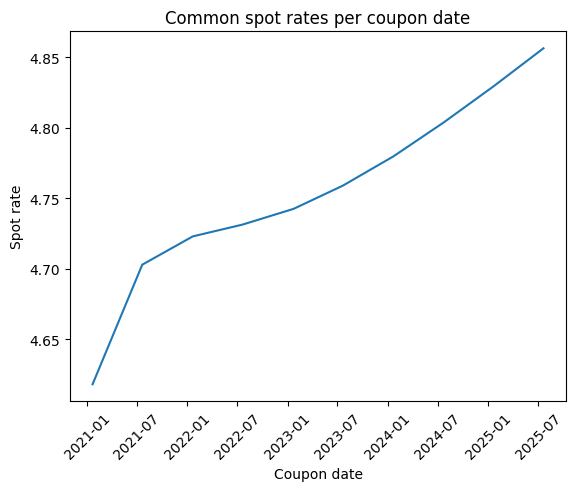

In [27]:
plt.figure()
plt.title("Common spot rates per coupon date")
plt.ylabel("Spot rate")
plt.xlabel("Coupon date")
plt.plot(coupon_dates_pandas_timestamps, scenarios_spot_rates[0]*100)
plt.xticks(rotation=45)
plt.show()

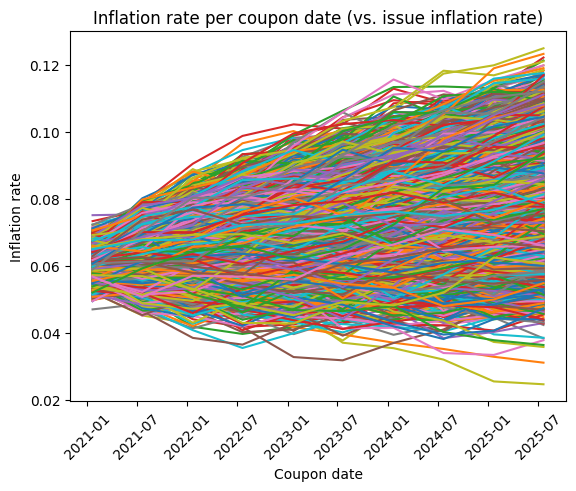

In [28]:
plt.figure()
plt.title("Inflation rate per coupon date (vs. issue inflation rate)")
plt.ylabel("Inflation rate")
plt.xlabel("Coupon date")
plt.plot(coupon_dates_pandas_timestamps, np.array(scenarios_inflation_rates).T)
plt.xticks(rotation=45)
plt.show()

In [29]:
scenarios_inflation_rate_df = pd.DataFrame(data=scenarios_inflation_rates, columns=coupon_dates)
scenarios_inflation_rate_df.describe()

,"January 21st, 2021","July 21st, 2021","January 21st, 2022","July 21st, 2022","January 23rd, 2023","July 21st, 2023","January 22nd, 2024","July 22nd, 2024","January 21st, 2025","July 21st, 2025"
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.060527,0.062705,0.064964,0.067210,0.069509,0.071763,0.073994,0.076261,0.078482,0.080812
std,0.003227,0.005079,0.006545,0.007708,0.008749,0.009691,0.010481,0.011209,0.011958,0.012616
min,0.046960,0.045049,0.038456,0.035447,0.032737,0.031765,0.035388,0.031978,0.025472,0.024620
25%,0.058329,0.059333,0.060590,0.062001,0.063608,0.065136,0.066844,0.068632,0.070392,0.072467
50%,0.060498,0.062710,0.064935,0.067207,0.069529,0.071675,0.074070,0.076217,0.078417,0.080800
75%,0.062679,0.066086,0.069370,0.072367,0.075390,0.078469,0.081141,0.083914,0.086667,0.089205
max,0.075062,0.080107,0.090413,0.098708,0.102156,0.106260,0.115542,0.118156,0.119779,0.124852


## Exercício 2

In [30]:
#date of valuation
valuation_date = ql.Date(9, 2, 2022)

#yield curve parameters
yield_curve_params = {
    'beta0' : 5.9/100,
    'beta1' : -1.6/100,
    'beta2' : -0.5/100,
    'beta3' : 1/100,
    'tau1' : 5,
    'tau2' : 0.5
}

def NSS_Sens(beta0=0.08, beta1=-0.03, beta2=-0.01, beta3=0, tau1=3, tau2=1, par=100, coupon_rate=None, maturity=None):
    
    ct = par * np.repeat(coupon_rate, maturity)
    ct[-1] += par

    theta_i = np.arange(1, maturity + 1)
    r0t = np.zeros(maturity)

    nss_curve = NelsonSiegelSvenssonCurve(
        beta0=beta0,
        beta1=beta1,
        beta2=beta2,
        beta3=beta3,
        tau1=tau1,
        tau2=tau2
    )

    for i in range(maturity):
        r0t[i] = nss_curve(theta_i[i])
    
    # dollar-durations
    #$D0 -> $D0 * Delta B0 (usually 1% - percentage of how much changed) = dollar cost per percentage shift in B0
    beta0_sens = -np.sum(ct * theta_i * np.exp(-theta_i * r0t))
    beta1_sens = -np.sum(ct * theta_i * (1 - np.exp(-theta_i / tau1)) / (theta_i / tau1) * np.exp(-theta_i * r0t))
    beta2_sens = -np.sum(ct * theta_i * ((1 - np.exp(-theta_i / tau1)) / (theta_i / tau1) - np.exp(-theta_i / tau1)) * np.exp(-theta_i * r0t))
    beta3_sens = -np.sum(ct * theta_i * ((1 - np.exp(-theta_i / tau2)) / (theta_i / tau2) - np.exp(-theta_i / tau2)) * np.exp(-theta_i * r0t))
    
    # parametric durations
    B0 = np.sum(ct * np.exp(-theta_i * r0t))

    D0 = -(1 / B0) * beta0_sens #fisher-weil duration -> time interpretation (para beta 0)
    D1 = -(1 / B0) * beta1_sens #do not have interpretation in time; percentage variation
    D2 = -(1 / B0) * beta2_sens #do not have interpretation in time
    D3 = -(1 / B0) * beta3_sens #do not have interpretation in time
    
    return {
        'B0': B0,
        '$D': {'Beta0': beta0_sens, 'Beta1': beta1_sens, 'Beta2': beta2_sens, 'Beta3': beta3_sens},
        'D': {'Beta0': D0, 'Beta1': D1, 'Beta2': D2, 'Beta3': D3}
    }
 
NSS_Sens(coupon_rate=0.05, maturity=2)

{'B0': 98.62725644011552,
 '$D': {'Beta0': -192.51331964195353,
  'Beta1': -141.08199284702826,
  'Beta2': -41.27935526952266,
  'Beta3': -57.02059053597501},
 'D': {'Beta0': 1.951928164592551,
  'Beta1': 1.4304564269481672,
  'Beta2': 0.4185390201397993,
  'Beta3': 0.5781423167803189}}

### a) Compute the level, slope and curvature durations and $durations of target portfolio.

In [35]:
def get_number_of_coupons_since_valuation(maturity, frequency=1):
    return len(get_coupon_dates(valuation_date, maturity, frequency)[1:])

In [37]:
portfolio_instruments = pd.DataFrame(
    data=[
        (4, ql.Date(1, 12, 2025), 10000),
        (7.75, ql.Date(4, 12, 2026), 250000),
        (4, ql.Date(6, 12, 2027), 50000),
        (7, ql.Date(10, 12, 2028), 100000),
        (5.75, ql.Date(3, 12, 2029), 10000),
        (5.5, ql.Date(9, 12, 2030), 200000),
        (4, ql.Date(6, 12, 2032), 15000),
        (4.75, ql.Date(3, 12, 2035), 10000),
        (4.5, ql.Date(3, 12, 2030), 30000),
        (5, ql.Date(4, 12, 2045), 75000),
        (4.5, ql.Date(4, 12, 2050), 100000),
        (4, ql.Date(1, 12, 2051), 10000),
        (5, ql.Date(1, 12, 2052), 10000),
    ],
    columns=["coupon", "maturity", "quantity"],
    index=np.arange(1, 13 + 1)
)

portfolio_instruments["coupons"] = portfolio_instruments["maturity"] \
    .apply(lambda m: get_number_of_coupons_since_valuation(m))

portfolio_instruments

,coupon,maturity,quantity,coupons
1,4.00,"December 1st, 2025",10000,4
2,7.75,"December 4th, 2026",250000,5
3,4.00,"December 6th, 2027",50000,6
4,7.00,"December 10th, 2028",100000,7
5,5.75,"December 3rd, 2029",10000,8
6,5.50,"December 9th, 2030",200000,9
7,4.00,"December 6th, 2032",15000,11
8,4.75,"December 3rd, 2035",10000,14
9,4.50,"December 3rd, 2030",30000,9
10,5.00,"December 4th, 2045",75000,24


In [38]:
portfolio_instrument_values = []

for i in range(0, portfolio_instruments.shape[0]):
    portfolio_instrument = portfolio_instruments.iloc[i]
    portfolio_instrument_values.append(NSS_Sens(
        **yield_curve_params, 
        coupon_rate=portfolio_instrument.coupon/100, 
        maturity=portfolio_instrument.coupons
    ))

# Compute risk measures
portfolio_instruments['B0'] = [value['B0'] for value in portfolio_instrument_values]
portfolio_instruments['$D0'] = [value['$D']['Beta0'] for value in portfolio_instrument_values]
portfolio_instruments['$D1'] = [value['$D']['Beta1'] for value in portfolio_instrument_values]
portfolio_instruments['$D2'] = [value['$D']['Beta2'] for value in portfolio_instrument_values]
portfolio_instruments['$D3'] = [value['$D']['Beta3'] for value in portfolio_instrument_values]
portfolio_instruments['D0'] = [value['D']['Beta0'] for value in portfolio_instrument_values]
portfolio_instruments['D1'] = [value['D']['Beta1'] for value in portfolio_instrument_values]

portfolio_instruments

,coupon,maturity,quantity,coupons,B0,$D0,$D1,$D2,$D3,D0,D1
1,4.00,"December 1st, 2025",10000,4,96.741840,-364.773162,-253.570334,-85.614198,-47.269958,3.770583,2.621103
2,7.75,"December 4th, 2026",250000,5,112.078569,-489.833335,-318.223827,-124.695553,-54.126416,4.370446,2.839292
3,4.00,"December 6th, 2027",50000,6,94.818814,-515.133810,-306.924136,-141.529338,-46.429136,5.432823,3.236954
4,7.00,"December 10th, 2028",100000,7,111.184284,-648.580915,-366.458550,-182.079150,-53.881402,5.833387,3.295956
5,5.75,"December 3rd, 2029",10000,8,104.097349,-692.930724,-364.937585,-199.303089,-50.643718,6.656565,3.505734
6,5.50,"December 9th, 2030",200000,9,102.416585,-752.446042,-372.663029,-218.160676,-49.864472,7.346916,3.638698
7,4.00,"December 6th, 2032",15000,11,89.786788,-805.365860,-351.328394,-232.385218,-43.916077,8.969759,3.912919
8,4.75,"December 3rd, 2035",10000,14,94.346398,-979.142143,-375.856441,-268.942872,-46.012635,10.378161,3.983792
9,4.50,"December 3rd, 2030",30000,9,95.321640,-719.373944,-353.010994,-209.452487,-46.561329,7.546806,3.703367
10,5.00,"December 4th, 2045",75000,24,93.343343,-1303.481225,-377.727857,-294.759653,-45.450025,13.964373,4.046650


In [39]:
portfolio_pv = (portfolio_instruments['B0'] * portfolio_instruments['quantity']).sum()
portfolio_pv

88705967.2539232

In [40]:
portfolio_instruments['weight'] = portfolio_instruments['quantity'] * portfolio_instruments['B0'] / portfolio_pv
portfolio_instruments

,coupon,maturity,quantity,coupons,B0,$D0,$D1,$D2,$D3,D0,D1,weight
1,4.00,"December 1st, 2025",10000,4,96.741840,-364.773162,-253.570334,-85.614198,-47.269958,3.770583,2.621103,0.010906
2,7.75,"December 4th, 2026",250000,5,112.078569,-489.833335,-318.223827,-124.695553,-54.126416,4.370446,2.839292,0.315871
3,4.00,"December 6th, 2027",50000,6,94.818814,-515.133810,-306.924136,-141.529338,-46.429136,5.432823,3.236954,0.053446
4,7.00,"December 10th, 2028",100000,7,111.184284,-648.580915,-366.458550,-182.079150,-53.881402,5.833387,3.295956,0.125340
5,5.75,"December 3rd, 2029",10000,8,104.097349,-692.930724,-364.937585,-199.303089,-50.643718,6.656565,3.505734,0.011735
6,5.50,"December 9th, 2030",200000,9,102.416585,-752.446042,-372.663029,-218.160676,-49.864472,7.346916,3.638698,0.230913
7,4.00,"December 6th, 2032",15000,11,89.786788,-805.365860,-351.328394,-232.385218,-43.916077,8.969759,3.912919,0.015183
8,4.75,"December 3rd, 2035",10000,14,94.346398,-979.142143,-375.856441,-268.942872,-46.012635,10.378161,3.983792,0.010636
9,4.50,"December 3rd, 2030",30000,9,95.321640,-719.373944,-353.010994,-209.452487,-46.561329,7.546806,3.703367,0.032237
10,5.00,"December 4th, 2045",75000,24,93.343343,-1303.481225,-377.727857,-294.759653,-45.450025,13.964373,4.046650,0.078921


In [41]:
portfolio_D0 = (portfolio_instruments['D0'] * portfolio_instruments['weight']).sum()
portfolio_D1 = (portfolio_instruments['D1'] * portfolio_instruments['weight']).sum()
portfolio_Dollar_D0 = (portfolio_instruments['$D0'] * portfolio_instruments['weight']).sum()
portfolio_Dollar_D1 = (portfolio_instruments['$D1'] * portfolio_instruments['weight']).sum()
portfolio_Dollar_D2 = (portfolio_instruments['$D2'] * portfolio_instruments['weight']).sum()
portfolio_Dollar_D3 = (portfolio_instruments['$D3'] * portfolio_instruments['weight']).sum()

print("Portfolio D0", portfolio_D0)
print("Portfolio D1", portfolio_D1)

portfolio_dollar_durations = np.array([
    portfolio_Dollar_D0, 
    portfolio_Dollar_D1,
    portfolio_Dollar_D2,
    portfolio_Dollar_D3
])

for i in range(0, 4):
    print(f"Portfolio $D{i}:", portfolio_dollar_durations[i])

Portfolio D0 7.585479686412395
Portfolio D1 3.3999509599563593
Portfolio $D0: -748.9729344912599
Portfolio $D1: -346.1140496496504
Portfolio $D2: -191.15643654596244
Portfolio $D3: -49.95181300234362


### b) Compute the level, slope and curvature durations and $durations of the hedging assets.

In [42]:
hedging_instruments = pd.DataFrame(
    data = [
        (4.5, ql.Date(12, 4,2026)),
        (5, ql.Date(28, 12, 2032)),
        (6, ql.Date(6, 5,2035)),
        (6, ql.Date(10, 10,2040)),
        (6.5, ql.Date(10, 10,2051))
    ],
    columns = ["coupon", "maturity"],
    index = np.arange(1,5+1)
)

hedging_instruments["coupons"] = hedging_instruments["maturity"] \
    .apply(lambda m: get_number_of_coupons_since_valuation(m))

hedging_instruments

,coupon,maturity,coupons
1,4.5,"April 12th, 2026",5
2,5.0,"December 28th, 2032",11
3,6.0,"May 6th, 2035",14
4,6.0,"October 10th, 2040",19
5,6.5,"October 10th, 2051",30


In [44]:
hedging_values = []

for i in range(0, hedging_instruments.shape[0]):
    hedging_instrument = hedging_instruments.iloc[i]
    hedging_values.append(NSS_Sens(
        **yield_curve_params, 
        coupon_rate=hedging_instrument.coupon/100, 
        maturity=round(count_years(valuation_date, hedging_instrument.maturity))
    ))

hedging_instruments['B0'] = [value['B0'] for value in hedging_values]
hedging_instruments['$D0'] = [value['$D']['Beta0'] for value in hedging_values]
hedging_instruments['$D1'] = [value['$D']['Beta1'] for value in hedging_values]
hedging_instruments['$D2'] = [value['$D']['Beta2'] for value in hedging_values]
hedging_instruments['$D3'] = [value['$D']['Beta3'] for value in hedging_values]
hedging_instruments['D0'] = [value['D']['Beta0'] for value in hedging_values]
hedging_instruments['D1'] = [value['D']['Beta1'] for value in hedging_values]

hedging_instruments

,coupon,maturity,coupons,B0,$D0,$D1,$D2,$D3,D0,D1
1,4.5,"April 12th, 2026",5,98.519792,-369.110696,-256.866378,-86.454640,-48.036885,3.746564,2.607257
2,5.0,"December 28th, 2032",11,98.049020,-850.678215,-376.096588,-244.706135,-47.802864,8.676050,3.835802
3,6.0,"May 6th, 2035",14,106.512956,-1008.870331,-411.896844,-281.838808,-51.790502,9.471809,3.867106
4,6.0,"October 10th, 2040",19,106.689206,-1276.296357,-424.561965,-318.647488,-51.878627,11.962751,3.979428
5,6.5,"October 10th, 2051",30,113.899468,-1657.114117,-454.819602,-351.412409,-55.361594,14.548919,3.993167


### c) Estimate the holdings of the hedging portfolio assuming the hedger wants to implement a self-financing (full) hedging strategy.

We can hedge the portfolio using the following matrix equation:

$$
\begin{pmatrix} 
\phi_1 \\ 
\phi_2 \\ 
\phi_3  \\
\phi_4 \\
\phi_5
\end{pmatrix}

= 

\begin{pmatrix} 
\$D_0^{H1} & \$D_0^{H2} & \$D_0^{H3} & \$D_0^{H4} & \$D_0^{H5} \\ 
\$D_1^{H1} & \$D_1^{H2} & \$D_1^{H3} & \$D_1^{H4} & \$D_1^{H5} \\ 
\$D_2^{H1} & \$D_2^{H2} & \$D_2^{H3} & \$D_2^{H4} & \$D_2^{H5} \\ 
\$D_3^{H1} & \$D_3^{H2} & \$D_3^{H3} & \$D_3^{H4} & \$D_3^{H5} \\ 
B_0^{H1} & B_0^{H2} & B_0^{H3} & B_0^{H4} & B_0^{H5}
\end{pmatrix}^{-1}

\times

\begin{pmatrix}
- \$ D_0^P \\
- \$ D_1^P \\
- \$ D_2^P \\
- \$ D_3^P \\
- PV_{P}
\end{pmatrix}

$$

We can start by forming the matrix to be inverted with the dollar durations of the hedging instruments:

In [45]:
dollar_duration_matrix = hedging_instruments[['$D0','$D1','$D2','$D3']].T
dollar_duration_matrix

,1,2,3,4,5
$D0,-369.110696,-850.678215,-1008.870331,-1276.296357,-1657.114117
$D1,-256.866378,-376.096588,-411.896844,-424.561965,-454.819602
$D2,-86.454640,-244.706135,-281.838808,-318.647488,-351.412409
$D3,-48.036885,-47.802864,-51.790502,-51.878627,-55.361594


Now we retrieve the bond values of the hedging instruments. The idea is equating them (multiplied by their respective quantities) to the portfolio present value, so we can "purchase" our portfolio using the shorts of hedge instruments, making it self-financing...

In [46]:
hedging_instruments_bond_values = hedging_instruments[['B0']].T
hedging_instruments_bond_values

,1,2,3,4,5
B0,98.519792,98.04902,106.512956,106.689206,113.899468


Combining them we get the matrix to be used (and inverted) on left hand side:

In [47]:
dollar_duration_matrix.loc['B0'] = hedging_instruments_bond_values.iloc[0]
dollar_duration_matrix

,1,2,3,4,5
$D0,-369.110696,-850.678215,-1008.870331,-1276.296357,-1657.114117
$D1,-256.866378,-376.096588,-411.896844,-424.561965,-454.819602
$D2,-86.454640,-244.706135,-281.838808,-318.647488,-351.412409
$D3,-48.036885,-47.802864,-51.790502,-51.878627,-55.361594
B0,98.519792,98.049020,106.512956,106.689206,113.899468


Now the left hand side, or the "solutions" of the equation systems. We start by combining the portfolio dollar durations and the portfolio PV (present value) for the self-financing constraint. We multiply the whole thing by -1, since we're changing signs to solve for phi's.

In [48]:
solutions = -np.concatenate([portfolio_dollar_durations.T, [portfolio_pv]]).T
solutions

array([ 7.48972934e+02,  3.46114050e+02,  1.91156437e+02,  4.99518130e+01,
       -8.87059673e+07])

Finally we can solve for phi (units of bonds to be shorted):

In [49]:
phis = np.linalg.solve(dollar_duration_matrix, solutions)
for i in range(0, len(phis)): print(f"phi_{i} = {phis[i]}")

phi_0 = 6711058.475930818
phi_1 = 314116164.09006244
phi_2 = -484306031.66594076
phi_3 = 263094572.27366638
phi_4 = -70528371.23473544


In [50]:
print("Difference between portfolio PV and hedging portfolio PV:", round(hedging_instruments['B0'] @ phis + portfolio_pv, 5))

Difference between portfolio PV and hedging portfolio PV: -3e-05


### d) Assume that immediately after the hedging strategy was established, the yield curve changed and is now given by the following set of NSS parameters

In [51]:
yield_curve_params

{'beta0': 0.059000000000000004,
 'beta1': -0.016,
 'beta2': -0.005,
 'beta3': 0.01,
 'tau1': 5,
 'tau2': 0.5}

In [52]:
import copy
#perform deep copy just in case
new_yield_curve_params = copy.deepcopy(yield_curve_params)

#Change and output new parameters
new_yield_curve_params['beta0'] = 6.5/100
new_yield_curve_params['beta1'] = -1/100
new_yield_curve_params['beta2'] = 0.1/100
new_yield_curve_params['beta3'] = 2/100
new_yield_curve_params

{'beta0': 0.065,
 'beta1': -0.01,
 'beta2': 0.001,
 'beta3': 0.02,
 'tau1': 5,
 'tau2': 0.5}

#### i. Estimate the impact of this shift in the yield curve on the Target Portfolio assuming no hedging strategy had been implemented. Discuss the results.

In [53]:
portfolio_instruments['B0*'] = portfolio_instruments.apply(
    lambda row: NSS_Sens(**new_yield_curve_params, coupon_rate=row['coupon']/100, maturity=round(count_years(valuation_date, row['maturity'])))['B0'],
    axis = 1
)
portfolio_instruments[['coupon', 'maturity', 'B0', 'B0*']]

,coupon,maturity,B0,B0*
1,4.00,"December 1st, 2025",96.741840,92.160777
2,7.75,"December 4th, 2026",112.078569,106.116564
3,4.00,"December 6th, 2027",94.818814,88.784257
4,7.00,"December 10th, 2028",111.184284,103.748234
5,5.75,"December 3rd, 2029",104.097349,96.378853
6,5.50,"December 9th, 2030",102.416585,94.241060
7,4.00,"December 6th, 2032",89.786788,81.470311
8,4.75,"December 3rd, 2035",94.346398,84.751810
9,4.50,"December 3rd, 2030",95.321640,87.534081
10,5.00,"December 4th, 2045",93.343343,81.996069


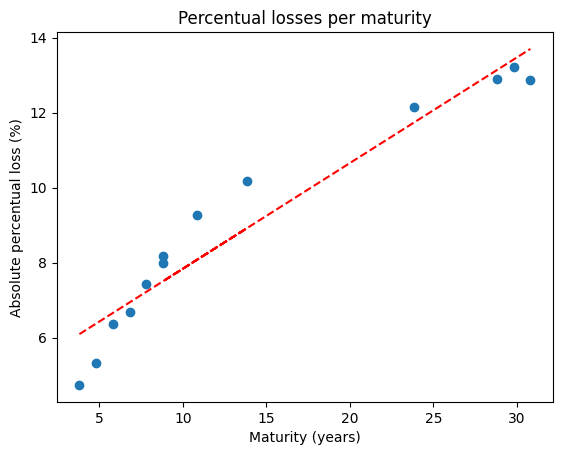

In [54]:
losses_per_maturity_x = portfolio_instruments['maturity'].apply(lambda m: count_years(valuation_date, m))
losses_per_maturity_y = abs((portfolio_instruments['B0*'] - portfolio_instruments['B0'])/portfolio_instruments['B0'])*100

plt.figure();
plt.scatter(losses_per_maturity_x, losses_per_maturity_y);
plt.title('Percentual losses per maturity');
plt.xlabel('Maturity (years)');
plt.ylabel('Absolute percentual loss (%)');

#draw trend line
p = np.poly1d(np.polyfit(losses_per_maturity_x, losses_per_maturity_y, 1))
plt.plot(losses_per_maturity_x, p(losses_per_maturity_x), color='red', linestyle='--');

In [55]:
portfolio_losses_no_hedging = ((portfolio_instruments['B0*']-portfolio_instruments['B0']) * portfolio_instruments['quantity']).sum()
portfolio_new_pv_no_hedging = portfolio_pv + portfolio_losses_no_hedging

print(f"Expected losses for the shifts in yield curve: {portfolio_losses_no_hedging}")
print(f"Previous portfolio PV was {portfolio_pv}, now will be {portfolio_new_pv_no_hedging}")
print(f"Percentual losses: {(portfolio_new_pv_no_hedging-portfolio_pv)/portfolio_pv * 100}%")

Expected losses for the shifts in yield curve: -6914865.942429821
Previous portfolio PV was 88705967.2539232, now will be 81791101.31149337
Percentual losses: -7.795265816374944%


#### ii. Estimate the impact of this change in the yield curve on the global portfolio (target bond portfolio plus hedging instruments) and discuss the performance of the hedging strategy. 

In [56]:
hedging_instruments['B0*'] = hedging_instruments.apply(
    lambda row: NSS_Sens(**new_yield_curve_params, coupon_rate=row['coupon']/100, maturity=round(count_days(valuation_date, row['maturity'])))['B0'],
    axis = 1
)
hedging_instruments[['coupon', 'maturity', 'B0', 'B0*']]

,coupon,maturity,B0,B0*
1,4.5,"April 12th, 2026",98.519792,68.795238
2,5.0,"December 28th, 2032",98.049020,76.439154
3,6.0,"May 6th, 2035",106.512956,91.726984
4,6.0,"October 10th, 2040",106.689206,91.726984
5,6.5,"October 10th, 2051",113.899468,99.370900


In [57]:
portfolio_loss = (hedging_instruments['B0*']-hedging_instruments['B0']) @ phis \
    + (portfolio_new_pv_no_hedging-portfolio_pv)

print(f"Portfolio loss after hedging was: {portfolio_loss/portfolio_pv*100}%")

Portfolio loss after hedging was: -3094.802045919286%
